# Optical Flow Filter
this notebook show the inference result of the OF filter in OOD case

**Because the limit of storage, the raw data cannot be uploaded, so plz donot run this notebook and just see the result**

In [1]:
%load_ext autoreload
! nvidia-smi

Thu Jul 13 13:44:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:18:00.0 Off |                  N/A |
| 40%   43C    P8    36W / 350W |     23MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:3B:00.0 Off |                  N/A |
| 36%   

In [2]:
%autoreload
import numpy as np
import os
import struct
import cv2,sys
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import math
sys.path.append("..")
sys.path.append("../datareader")
sys.path.append("../demo")
import rawDataReadTool as rdrt
dataset = rdrt.TianmoucDataRead(8,dataset_top = "/data/taoyi/dataset/Lyncam/driving_dataset/20230417")
from lib.utils import lyncam_raw_comp
from lib.basic_isp import demosaicing_npy

rushwhenDrive6 rod 3938
rushwhenDrive6 cone 315
rushwhenDrive2 rod 8868
rushwhenDrive2 cone 709
openroad1 rod 14175
openroad1 cone 1134
openroad4 rod 5208
openroad4 cone 417
openroad2 rod 8877
openroad2 cone 710
rushwhenDrive4 rod 10186
rushwhenDrive4 cone 815
tsk5 rod 11102
tsk5 cone 888
openroad3 rod 8244
openroad3 cone 659
rushwhenDrive3 rod 9963
rushwhenDrive3 cone 797
dropB3 rod 4743
dropB3 cone 379
rushwhenDrive5 rod 1632
rushwhenDrive5 cone 130
tsk rod 9332
tsk cone 746
tsk2 rod 5923
tsk2 cone 474
ballintunnel2 rod 3174
ballintunnel2 cone 254
dropB2 rod 1672
dropB2 cone 134
dropBwhenDrive4 rod 5239
dropBwhenDrive4 cone 419
dropBwhenDrive3 rod 8089
dropBwhenDrive3 cone 647
dropB rod 1230
dropB cone 98
rushwhenDrive1 rod 2262
rushwhenDrive1 cone 181
dropBwhenDrive5_best rod 3304
dropBwhenDrive5_best cone 264
dropBwhenDrive1 rod 6509
dropBwhenDrive1 cone 521
tsk6_best rod 6956
tsk6_best cone 557
openroad5 rod 4445
openroad5 cone 356
tsk4 rod 6654
tsk4 cone 532
stopBypath rod 6063
s

import TianmouCV, via Y. Lin, T. Wang


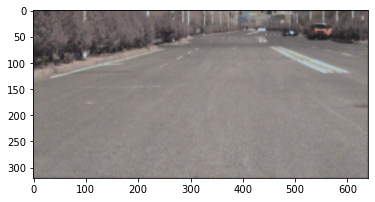

In [3]:
%autoreload
from tianmoucv.alg import cal_optical_flow,backWarp,flow_to_image
from tianmoucv.nn import compute_iou
from opticalFilter import opticalDetector_Maxone
    
name = 'rushwhenDrive1'
rgb,td,sd,rodtimeStamp,conetimeStamp,_ = dataset.readFile(name,100,0,viz=False,ifSync =True)
rgb = rgb/1024


def ispRGB(rgb,flip = False):
    rgb[:,:,0] *= 0.7 #r
    rgb[:,:,1] *= 0.8 #g
    rgb[:,:,2] *= 1 #b
    if flip:
        rgb = rgb[::-1,:,:]
    return rgb

plt.imshow(ispRGB(rgb,flip = False))
plt.show()

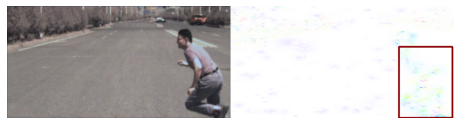

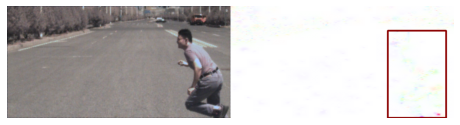

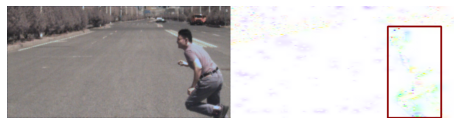

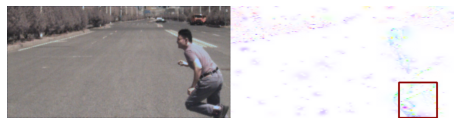

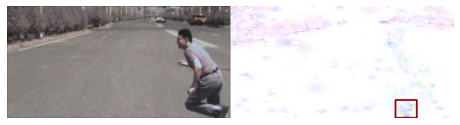

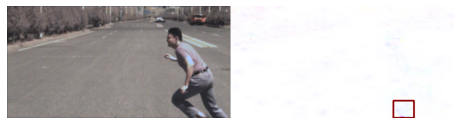

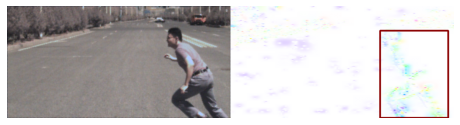

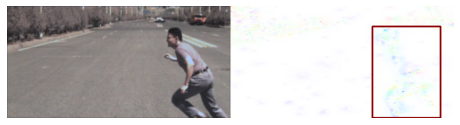

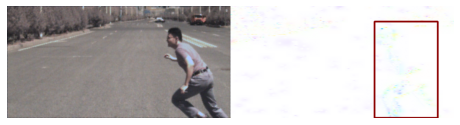

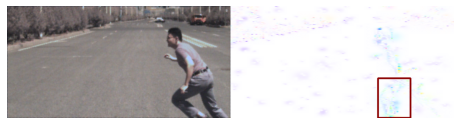

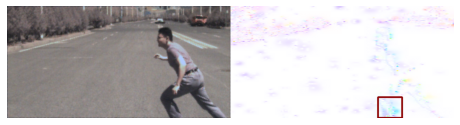

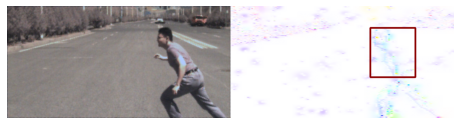

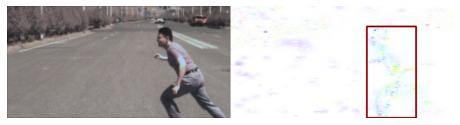

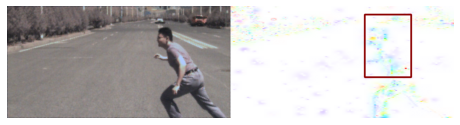

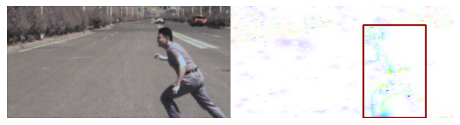

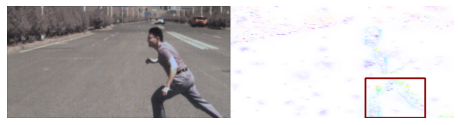

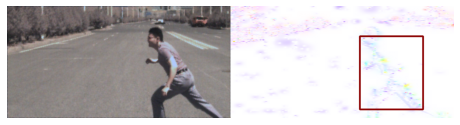

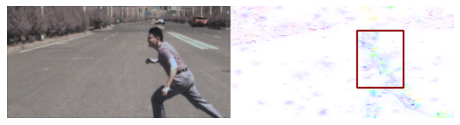

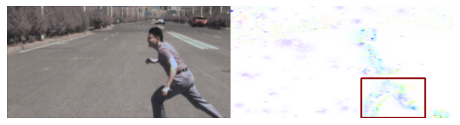

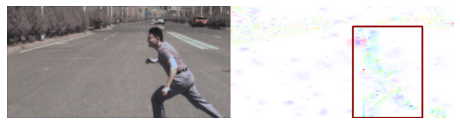

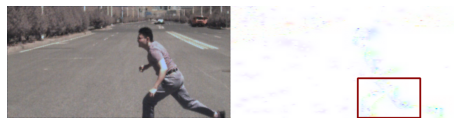

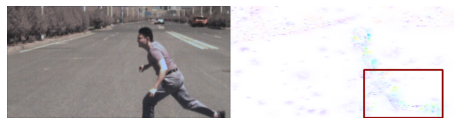

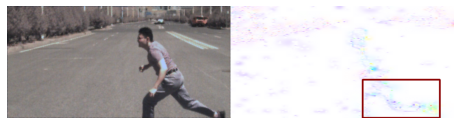

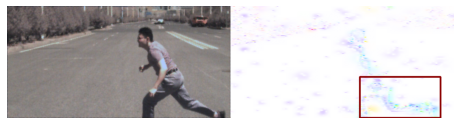

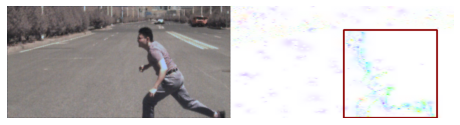

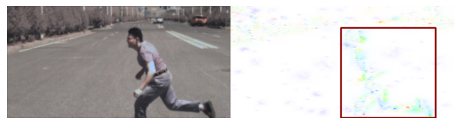

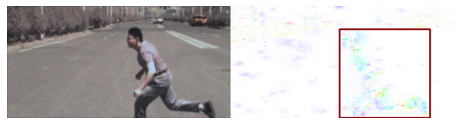

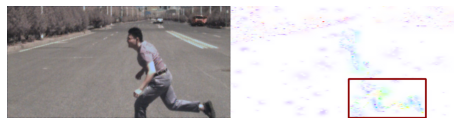

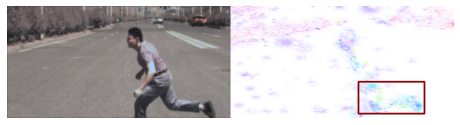

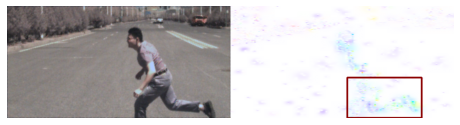

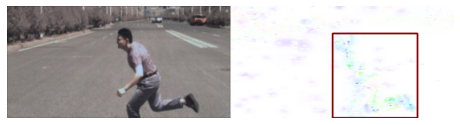

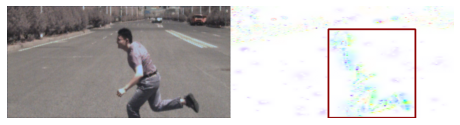

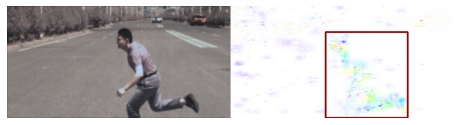

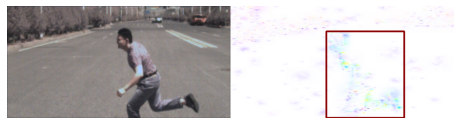

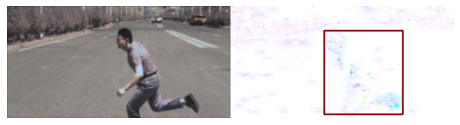

In [ ]:
%autoreload

name = 'rushwhenDrive1'

imlist = []

accumTime = 5
t0 = 100
t0 = 130
count = 0
succ = 0
accumalationShow = torch.ones([320,640,3]).numpy() * 255.0
oldCentral = None
optifilt = opticalDetector_Maxone(noiseThresh = 1.5*accumTime,distanceThresh=0.8)

for j in range(20):
    if (j%2 == 0):
        accumalationShow = torch.ones([320,640,3]).numpy() * 255.0
    for b in range(25//accumTime):

        bias = b * accumTime
        sd = 0
        td = 0
        noiseThresh = 1.6*accumTime
        start = t0 + j
        for i in range(accumTime):
            
            rgb,tdt,sdt,rodtimeStamp,conetimeStamp ,_= dataset.readFile(name,start,start*(25)+bias+i,viz=False,ifSync =False)
            
            Ix = np.zeros(tdt.shape)
            Iy = np.zeros(tdt.shape)
            sdul = sdt[0::2,...,0]
            sdll = sdt[1::2,...,0]
            sdur = sdt[0::2,...,1]
            sdlr = sdt[1::2,...,1]
            Ix[::2,...] = Ix[1::2,...]= (-(sdul + sdll)/1.414 + (sdur + sdlr)/1.414)/2
            Iy[1::2,...]= Iy[::2,...] = ((sdur - sdlr)/1.414 + (sdul - sdll)/1.414)/2
            sd += torch.FloatTensor(np.stack([Ix,Iy],axis=2))
            td += -tdt
            sdr = sdt[:,:,1] 
            TD_show = torch.zeros([160,160,3])
            TD_show[:,:,0][tdt>0] = torch.abs(tdt[tdt>0])
            TD_show[:,:,1][tdt<0] = torch.abs(tdt[tdt<0])
            SDR_show = torch.zeros([160,160,3])
            SDR_show[:,:,0][sdr>0] = torch.abs(sdr[sdr>0])
            SDR_show[:,:,1][sdr<0] = torch.abs(sdr[sdr<0])
            TD_show /= 16
            SDR_show /= 16
            TDnum = TD_show.numpy()
            SDnum = SDR_show.numpy()

        sd = sd.permute(2,0,1)
        td = td.unsqueeze(0)
        count += 1
        box,dis,flowup = optifilt(sd,td)
        
        rgb,tdt,sdt,rodtimeStamp,conetimeStamp,_ = dataset.readFile(name,start,0,viz=False,ifSync =False)
        rgb = ispRGB(rgb/1024.0,flip = False)
        dis /= 255.0
        #print(x1,y1,x2,y2,np.max(area))
        if not box is None:
            x1,y1,x2,y2 = box 
            succ += 1
            cv2.rectangle(flowup, (int(x1),int(y1)), (int(x2),int(y2)), (139/255.0,0,0), 3)
            cv2.rectangle(accumalationShow, (int(x1),int(y1)), (int(x2),int(y2)), (139, 0, 0), 3)
            if not oldCentral is None:
                cv2.line(accumalationShow, (int((x1+x2)/2),int((y1+y2)/2)), oldCentral, (255, 0, 0), 1)
            oldCentral =(int((x1+x2)/2),int((y1+y2)/2))
        
        if flowup is None:
            flowup = np.ones(rgb.shape)
        plt.figure(figsize=(8,8))
        showim = np.concatenate([rgb,flowup],axis=1)
        imlist.append(showim)
        plt.imshow(showim)
        plt.axis('off') 
        plt.show()

In [ ]:
def images_to_video(frame_list,name,Val_size=(512,256)):
    fps = 5          
    size = (Val_size[0]*2, Val_size[1]) # 需要转为视频的图片的尺寸
    out = cv2.VideoWriter(name, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for frame in frame_list:
        frame = frame[:,:,[2,1,0]] * 255
        w = Val_size[0]
        h = Val_size[1]
        frame = frame.astype(np.uint8)
        out.write(frame)
    out.release()

images_to_video(imlist,'../../results/'+name+'OF.avi',Val_size=(640,320))